In [13]:
import numpy as np
np.set_printoptions(threshold=10000, suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

# Partie 1

## Chargement et visualisation des données

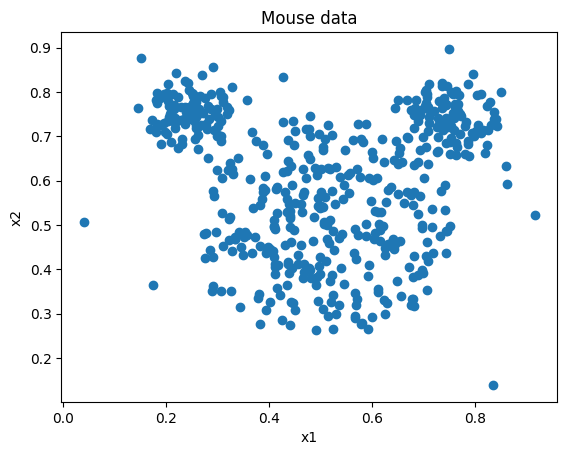

In [14]:
mickey = np.loadtxt('mouse.txt')
x1 = mickey[:,0]
x2 = mickey[:,1]

plt.scatter(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Mouse data')
plt.show()

## Isolation Forest

In [15]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=100, max_samples='auto')
iforest.fit(mickey)

df = pd.DataFrame(mickey)
df['scores'] = iforest.decision_function(mickey)
# -1 for outliers, 1 for inliers
df['anomaly'] = iforest.predict(mickey)
df.head(20)

,0,1,scores,anomaly
0,0.456601,0.432806,0.040876,1
1,0.611378,0.528625,0.032970,1
2,0.450299,0.711606,0.006967,1
3,0.639015,0.460744,0.040724,1
4,0.628957,0.323470,-0.010814,-1
5,0.566210,0.289358,-0.034078,-1
6,0.567653,0.295473,-0.020086,-1
7,0.436024,0.415776,0.040815,1
8,0.545414,0.367502,0.012577,1
9,0.439453,0.547867,0.035536,1


In [16]:
anomaly = df.loc[df['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(len(anomaly))

127


## Local Outlier Factor

In [17]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
pred = lof.fit_predict(mickey)

# -1 for outliers, 1 for inliers
print(pred)


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1

## Mieux choisir le seuil de contamination

### Méthode 1 : Visualisation des anomalies - Isolation Forest

Pour cette méthode, nous allons visualiser l'histogramme des scores de l'Isolation Forest. Nous allons ensuite calculer le seuil de contamination optimal.

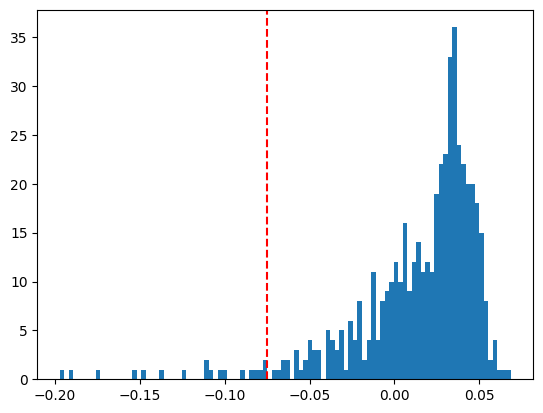

In [29]:
scrores = df['scores']

# récupérer les informations de l'histogramme
frequencies, bins = np.histogram(scrores, bins=100)

# calculer la pente de chaque barre
bin_diff = np.diff(bins)
slope = np.diff(frequencies) / bin_diff[:-1]

# trouver le seuil
threshold_index = np.where(slope < -np.abs(slope).max()*0.09)[0][0]
threshold = bins[threshold_index +1]

plt.hist(scrores, bins=100)
plt.axvline(threshold, color='red', linestyle='--')


In [30]:
nombre_sous_seuil = (df['scores'] < threshold).sum()
print("Pourcentage d'erreur : ",nombre_sous_seuil*100/len(df), '%')

Pourcentage d'erreur :  3.6 %


### Méthode 2 : Calculer le seuil avec un Z-score - Isolation Forest

Pour cette méthode, nous allons calculer le seuil de contamination optimal en utilisant un Z-score.

In [31]:
lof_scores = lof.negative_outlier_factor_
# Calcul du seuil avec Z-score
threshold = np.mean(lof_scores) - 3 * np.std(lof_scores)

print("Seuil LOF : ", threshold)
nombre_sous_seuil = (lof_scores < threshold).sum()
print("Pourcentage d'erreur LOF : ",nombre_sous_seuil*100/len(df), '%')

Seuil LOF :  -1.7885302876387439
Pourcentage d'erreur LOF :  1.6 %


## Visualisation des données aberrantes

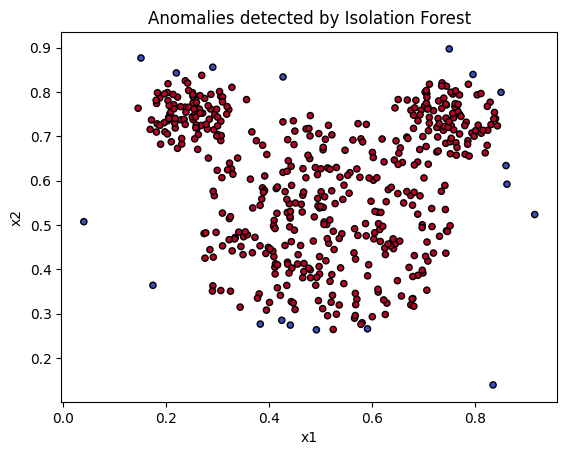

In [32]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.036)
iforest.fit(mickey)
df['scores'] = iforest.decision_function(mickey)
df['anomaly'] = iforest.predict(mickey)
plt.scatter(x1, x2, c=df['anomaly'], cmap='coolwarm', s=20, edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Anomalies detected by Isolation Forest')
plt.show()

In [33]:
# print les index des anomalies
anomaly = df.loc[df['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(anomaly_index)

[18, 84, 111, 194, 197, 387, 398, 424, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]


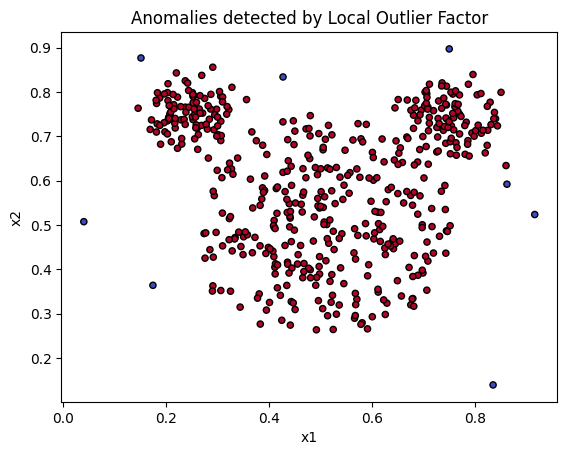

In [34]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.016)
pred = lof.fit_predict(mickey)
plt.scatter(x1, x2, c=pred, cmap='coolwarm', s=20, edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Anomalies detected by Local Outlier Factor')
plt.show()

In [35]:
# print les index des anomalies
anomaly = df.loc[pred == -1]
anomaly_index = list(anomaly.index)
print(anomaly_index)

[491, 492, 493, 494, 495, 497, 498, 499]


## Comparaison des méthodes

La méthode Isolation Forest avec un seuil de contamination calculé grâce à l'histogramme, permet de détecter toutes les anomalies. Cepedant, elle détecter aussi des points comme étant anormal alors qu'il ne le sont pas. D'un autre côté, la méthode Local Outlier Factor avec Z-scores permet de détecter les anomalies mais ne les trouve pas toutes. Aucune méthode n'est meilleur que l'autre, cela dépend si l'on veut détecter toutes les anomalies ou si l'on veut éviter de faux positifs.